In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd

import os
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re

import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split as tts

from keras.models import Model
from keras.layers import Input, LSTM, Embedding, Dense

### READING THE DATASET

In [ ]:
lines=pd.read_csv("/content/drive/MyDrive/VIT SEM/WINTER20-21/E1_CSE1015_MACHINELEARNINGESSENTIALS/PROJECT/END/Hindi_English_Truncated_Corpus.csv",encoding='utf-8')

### PREPROCESSING

In [ ]:
lines['source'].value_counts()

tides        50000
ted          39881
indic2012    37726
Name: source, dtype: int64



1.   USING TED SOURCE



In [ ]:
lines=lines[lines['source']=='ted']

In [ ]:
lines.head()

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
7,ted,"And who are we to say, even, that they are wrong",और हम होते कौन हैं यह कहने भी वाले कि वे गलत हैं
13,ted,So there is some sort of justice,तो वहाँ न्याय है


2. DROPPING NULL VALUES

In [ ]:
pd.isnull(lines).sum()

source              0
english_sentence    0
hindi_sentence      0
dtype: int64

In [ ]:
lines=lines[~pd.isnull(lines['english_sentence'])]

In [ ]:
lines.shape

(39881, 3)

3. DROPPING DUPLICATES

In [ ]:
lines.drop_duplicates(inplace=True)

In [ ]:
lines.shape

(38803, 3)

4. CHANGING ALL TO LOWERCASE CHARACTERS

In [ ]:
# Lowercase all characters
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.lower())
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.lower())

5. REMOVING QUOTES

In [ ]:
# Remove quotes
lines['english_sentence']=lines['english_sentence'].apply(lambda x: re.sub("'", '', x))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: re.sub("'", '', x))

# Remove quotes
lines['english_sentence']=lines['english_sentence'].apply(lambda x: re.sub("“", '', x))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: re.sub("“", '', x))

# Remove quotes
lines['english_sentence']=lines['english_sentence'].apply(lambda x: re.sub("”", '', x))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: re.sub("”", '', x))

6. REMOVING SPECIAL CHARACTERS

In [ ]:
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines['english_sentence']=lines['english_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

7. REMOVING DIGITS
8. REMOVING EXTRA SPACES

In [ ]:
remove_digits = str.maketrans('', '', digits)
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.translate(remove_digits))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.translate(remove_digits))

lines['hindi_sentence'] = lines['hindi_sentence'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

# Remove extra spaces
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.strip())
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.strip())
lines['english_sentence']=lines['english_sentence'].apply(lambda x: re.sub(" +", " ", x))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: re.sub(" +", " ", x))

9. ADDING < START > AND < END > TOKENS

In [ ]:
# Add start and end tokens to target sequences
lines['hindi_sentence'] = lines['hindi_sentence'].apply(lambda x : 'START_ '+ x + ' _END')
lines.head()

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,START_ राजनीतिज्ञों के पास जो कार्य करना चाहिए...
1,ted,id like to tell you about one such child,START_ मई आपको ऐसे ही एक बच्चे के बारे में बता...
3,ted,what we really mean is that theyre bad at not ...,START_ हम ये नहीं कहना चाहते कि वो ध्यान नहीं ...
7,ted,and who are we to say even that they are wrong,START_ और हम होते कौन हैं यह कहने भी वाले कि व...
13,ted,so there is some sort of justice,START_ तो वहाँ न्याय है _END


10. CREATING ENGLISH AND HINDI VOCABULARY

In [ ]:
### Get English and Hindi Vocabulary
all_eng_words=set()
for eng in lines['english_sentence']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

all_hindi_words=set()
for hin in lines['hindi_sentence']:
    for word in hin.split():
        if word not in all_hindi_words:
            all_hindi_words.add(word)
            
len(all_eng_words)

16293

In [ ]:
len(all_hindi_words)

21587

In [ ]:
lines['length_eng_sentence']=lines['english_sentence'].apply(lambda x:len(x.split(" ")))
lines['length_hin_sentence']=lines['hindi_sentence'].apply(lambda x:len(x.split(" ")))
lines.head()

,source,english_sentence,hindi_sentence,length_eng_sentence,length_hin_sentence
0,ted,politicians do not have permission to do what ...,START_ राजनीतिज्ञों के पास जो कार्य करना चाहिए...,12,15
1,ted,id like to tell you about one such child,START_ मई आपको ऐसे ही एक बच्चे के बारे में बता...,9,13
3,ted,what we really mean is that theyre bad at not ...,START_ हम ये नहीं कहना चाहते कि वो ध्यान नहीं ...,12,13
7,ted,and who are we to say even that they are wrong,START_ और हम होते कौन हैं यह कहने भी वाले कि व...,11,15
13,ted,so there is some sort of justice,START_ तो वहाँ न्याय है _END,7,6


11. SETTING EQUAL MAXIMUM LENGTH OF ENGLSIH AND HINDI SENTENCES   
```DRAWBACK OF LSTM```

In [ ]:
lines[lines['length_eng_sentence']>30].shape

(0, 5)

In [ ]:
lines[lines['length_eng_sentence']>=20].shape

(13, 5)

In [ ]:
lines=lines[lines['length_eng_sentence']<=20]
lines=lines[lines['length_hin_sentence']<=20]
lines.shape

(38477, 5)

In [ ]:
print("maximum length of Hindi Sentence ",max(lines['length_hin_sentence']))
print("maximum length of English Sentence ",max(lines['length_eng_sentence']))

maximum length of Hindi Sentence  20
maximum length of English Sentence  20


In [ ]:
max_length_src=max(lines['length_hin_sentence'])
max_length_tar=max(lines['length_eng_sentence'])
print(max_length_src)

20


In [ ]:
# Differentiating input and target
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_hindi_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_hindi_words)
num_encoder_tokens, num_decoder_tokens

(16293, 21587)

In [ ]:
num_decoder_tokens += 1 #for zero padding

12. TOKENIZATION

In [ ]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [ ]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [ ]:
lines = shuffle(lines)
lines.head()

,source,english_sentence,hindi_sentence,length_eng_sentence,length_hin_sentence
8574,ted,in his deeply authentic self,START_ अपने दिल की गहराइयों से _END,5,7
87751,ted,sold his child for pornography,START_ अपने बच्चे को अश्लील चित्रों के लिए बेच...,5,11
16526,ted,from wb yeats whos someone you may know,START_ डब्ल्यू बी अट्स से लिख्ति जिसे तुम में ...,8,14
61868,ted,dont read them bedtime stories every night,START_ उन्हें हर रात को कहानी मत सुनाइये । _END,7,10
124009,ted,one man whipping her,START_ एक आदमी जो उसे पीटता है _END,4,8


### MODEL PREPARATION

1. TRAIN AND TEST SPLIT

In [ ]:
X, y = lines['english_sentence'], lines['hindi_sentence']
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.2,random_state=42)
X_train.shape, X_test.shape,y_train.shape, y_test.shape

((30781,), (7696,), (30781,), (7696,))

2. SAVING PROCESSED DATA

In [ ]:
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')

3. GENERATING BATCHES

In [ ]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

4. ENCODER-DECODER ARCHITECTURE

In [ ]:
latent_dim=500

In [ ]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb_layer =  Embedding(num_encoder_tokens + 1, latent_dim, mask_zero = True)
enc_emb = enc_emb_layer(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [ ]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens + 1, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

5. MODEL SUMMARY

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 500)    8147000     input_5[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 500)    10794500    input_6[0][0]                    
____________________________________________________________________________________________

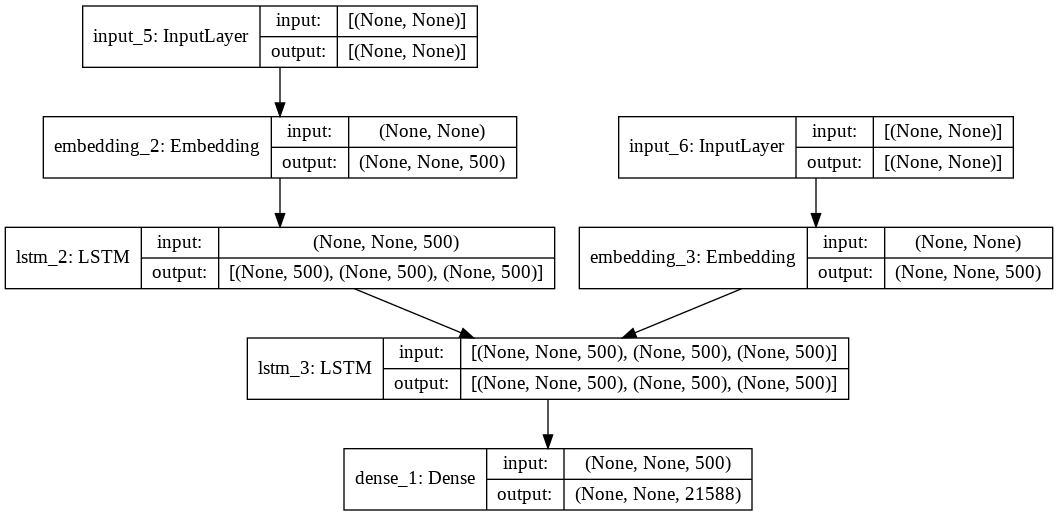

In [ ]:
import tensorflow as tf
dot_img_file = '/content/drive/MyDrive/VIT SEM/WINTER20-21/E1_CSE1015_MACHINELEARNINGESSENTIALS/PROJECT/Text_EnglishToHindi/2/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

6. TRAINING

In [ ]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 100

In [ ]:
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Epoch 1/100
240/240 [==============================] - 52s 185ms/step - loss: 3.0800 - val_loss: 2.6445
Epoch 2/100
240/240 [==============================] - 42s 174ms/step - loss: 2.5439 - val_loss: 2.4957
Epoch 3/100
240/240 [==============================] - 42s 173ms/step - loss: 2.3622 - val_loss: 2.4054
Epoch 4/100
240/240 [==============================] - 41s 172ms/step - loss: 2.2224 - val_loss: 2.3419
Epoch 5/100
240/240 [==============================] - 42s 173ms/step - loss: 2.0990 - val_loss: 2.3061
Epoch 6/100
240/240 [==============================] - 42s 173ms/step - loss: 1.9865 - val_loss: 2.2947
Epoch 7/100
240/240 [==============================] - 40s 169ms/step - loss: 1.8769 - val_loss: 2.2876
Epoch 8/100
240/240 [==============================] - 42s 174ms/step - loss: 1.7761 - val_loss: 2.2990
Epoch 9/100
240/240 [==============================] - 40s 169ms/step - loss: 1.6806 - val_loss: 2.2994
Epoch 10/100
240/240 [==============================] - 41s 172m

7. SAVE THE MODEL
8. LOAD THE MODEL

In [ ]:
model.save_weights('/content/drive/MyDrive/VIT SEM/WINTER20-21/E1_CSE1015_MACHINELEARNINGESSENTIALS/PROJECT/Text_EnglishToHindi/2/nmt_weights.h5')

In [ ]:
model.load_weights('/content/drive/MyDrive/VIT SEM/WINTER20-21/E1_CSE1015_MACHINELEARNINGESSENTIALS/PROJECT/Text_EnglishToHindi/2/nmt_weights.h5')

### PREDICTIONS
```ALONG WITH THE INDIVIDUAL BLEU SCORES```

1. ENCODER-DECODER FOR OUTPUT

In [ ]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

2. RESULTS

In [ ]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)

In [ ]:
import random
import nltk
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Output and the coresposponding BLEU score
k=random.randint(0,X_train.shape[0])
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
candidate = decoded_sentence
refer = y_train[k:k+1].values[0][6:-4]
bleu1 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])
print(bleu1)

Input English sentence: when i do my work
Actual Hindi Translation:  जब मैं अपना काम करता हूँ 
Predicted Hindi Translation:  हमने वैज्ञानिक क्रांतियाँ उन्होंने शुरुवात किया। 
0.41390665966698603


In [ ]:
k=random.randint(0,X_train.shape[0])
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
candidate = decoded_sentence
refer = y_train[k:k+1].values[0][6:-4]
bleu2 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])
print(bleu2)

Input English sentence: here was some lawyer or money manager
Actual Hindi Translation:  वो एक वकील या मैनेजर था 
Predicted Hindi Translation:  तो ये कठपुतली अध्यापकों और अभिभावकों ने सारे व
0.48405751151242604


In [ ]:
k=random.randint(0,X_train.shape[0])
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
candidate = decoded_sentence
refer = y_train[k:k+1].values[0][6:-4]
bleu3 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])
print(bleu3)

Input English sentence: show us the grades
Actual Hindi Translation:  हमें उनकी प्रगति दिखाईये 
Predicted Hindi Translation:  आप चुनौतीपूर्ण हो 
0.33702602309959623


In [ ]:
k=random.randint(0,X_train.shape[0])
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
candidate = decoded_sentence
refer = y_train[k:k+1].values[0][6:-4]
bleu4 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])
print(bleu4)

Input English sentence: the incremental advances have added up to something
Actual Hindi Translation:  वृद्धिशील विकास का नतीजा इस तरह का है 
Predicted Hindi Translation:  हम उस समय ब्रांक्स में रहा करते थे 
0.5266403878479265


In [ ]:
k=random.randint(0,X_train.shape[0])
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
candidate = decoded_sentence
refer = y_train[k:k+1].values[0][6:-4]
bleu5 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])
print(bleu5)

Input English sentence: now let me take you back to parol
Actual Hindi Translation:  अब मैं आपको वापस परोल में लेके चलता हूँ 
Predicted Hindi Translation:  मुझे यह बड़ी बुद्दिमानी की बात थी 
0.36973125629436004


In [ ]:
k=random.randint(0,X_train.shape[0])
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
candidate = decoded_sentence
refer = y_train[k:k+1].values[0][6:-4]
bleu6 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])
print(bleu6)

Input English sentence: food is gold there
Actual Hindi Translation:  यहाँ खाना ही सोना है 
Predicted Hindi Translation:  दसियों लाख औरतें 
0.7997513045108656


In [ ]:
k=random.randint(0,X_train.shape[0])
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
candidate = decoded_sentence
refer = y_train[k:k+1].values[0][6:-4]
bleu7 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])
print(bleu7)

Input English sentence: maybe they came with very little
Actual Hindi Translation:  वो अपने साथ बहुत थोडा कुछ ले कर आये थे 
Predicted Hindi Translation:  और क्या सोचते है आप इन लोगोके बारे मई 
0.6330238354869961


In [ ]:
k=random.randint(0,X_train.shape[0])
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
candidate = decoded_sentence
refer = y_train[k:k+1].values[0][6:-4]
bleu8 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])
print(bleu8)

Input English sentence: imagine a big explosion
Actual Hindi Translation:  सोचिये एक बडे विस्फ़ोट के बारे में 
Predicted Hindi Translation:  तो उसे या बेहतरीन ही महसूस नहीं सकता 
0.4908985092215497


In [ ]:
k=random.randint(0,X_train.shape[0])
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
candidate = decoded_sentence
refer = y_train[k:k+1].values[0][6:-4]
bleu9 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])
print(bleu9)

Input English sentence: i heard their prayer
Actual Hindi Translation:  उनकी प्रार्थनाएँ सुनी 
Predicted Hindi Translation:  ऊँटगाड़ी के उपयोग हेतु। 
0.4057108879449503


In [ ]:
k=random.randint(0,X_train.shape[0])
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
candidate = decoded_sentence
refer = y_train[k:k+1].values[0][6:-4]
bleu10 = nltk.translate.bleu_score.sentence_bleu(references=[refer, refer], hypothesis=candidate, weights=(0.25,0.25,0.25,0.25))

print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])
print(bleu10)

Input English sentence: like iraq egypt and syria
Actual Hindi Translation:  जैसा इराक मिस्र और सीरिया 
Predicted Hindi Translation:  उन्होंने एक साधारण बात लिखी 
0.45434646027144593


### AVERAGE BLEU SCORE

In [ ]:
#BLEU Score
bleu = (bleu1+bleu2+bleu3+bleu4+bleu5+bleu6+bleu7+bleu8+bleu9+bleu10)/10
print('Average BLEU Score of the Model:', bleu)

Average BLEU Score of the Model: 0.49150928358571033
